In [ ]:
! unzip archive.zip

Archive:  archive.zip
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from textblob import TextBlob
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
df_test = pd.read_csv('/content/test.csv')
df_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [ ]:
# пустых значений нет
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


пустых значений нет

 думаю, что здесь нет дубликатов

In [ ]:
# баланс классов
df_train.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

Подготовим наши данные - удалим все лишнее ( знаки препинания, предлоги местоимения и тд)
Все, что встречается часто как связь речи, но не несет особый смысл в нашем обучении
Подготовим оставшиеся данные так, чтобы они были одного формата (например нижний регистр)

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# заменяем стоп слова пробелом

In [ ]:
def stop_words_removal(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    print(df['tweet'].head())

In [ ]:
stop_words_removal(df_train)

0    @user father dysfunctional selfish drags kids ...
1    @user @user thanks #lyft credit can't use caus...
2                                       bihday majesty
3    #model love u take u time urð±!!! ððð...
4                      factsguide: society #motivation
Name: tweet, dtype: object


In [ ]:
stop_words_removal(df_test)

0    #studiolife #aislife #requires #passion #dedic...
1    @user #white #supremacists want everyone see n...
2    safe ways heal #acne!! #altwaystoheal #healthy...
3    hp cursed child book reservations already? yes...
4    3rd #bihday amazing, hilarious #nephew eli ahm...
Name: tweet, dtype: object


Заменим знаки препинания и прочую пунктуацию на пробел

In [ ]:
def punctuation_removal(df):
    df['tweet'] = df['tweet'].str.replace('[^\w\s]','')
    print(df['tweet'].head())

In [ ]:
punctuation_removal(df_train)
punctuation_removal(df_test)

0    user father dysfunctional selfish drags kids d...
1    user user thanks lyft credit cant use cause of...
2                                       bihday majesty
3                model love u take u time urð ðððð ððð
4                        factsguide society motivation
Name: tweet, dtype: object
0    studiolife aislife requires passion dedication...
1    user white supremacists want everyone see new ...
2    safe ways heal acne altwaystoheal healthy healing
3    hp cursed child book reservations already yes ...
4    3rd bihday amazing hilarious nephew eli ahmir ...
Name: tweet, dtype: object


Переведем все в нижний регистр

In [ ]:

def lower_case(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    print(df['tweet'].head())

In [ ]:
lower_case(df_train)
lower_case(df_test)

0    user father dysfunctional selfish drags kids d...
1    user user thanks lyft credit cant use cause of...
2                                       bihday majesty
3                model love u take u time urð ðððð ððð
4                        factsguide society motivation
Name: tweet, dtype: object
0    studiolife aislife requires passion dedication...
1    user white supremacists want everyone see new ...
2    safe ways heal acne altwaystoheal healthy healing
3    hp cursed child book reservations already yes ...
4    3rd bihday amazing hilarious nephew eli ahmir ...
Name: tweet, dtype: object


Остались только нужные нам слова, некоторые из них встречаются часто, некоторые редко

Поправим орфографию с помощью библиотеки textblob

In [ ]:
def spell_correction(df):
    return df['tweet'][:5].apply(lambda x: str(TextBlob(x).correct()))

In [ ]:
spell_correction(df_train)
spell_correction(df_test)

0    studiolife dislike requires passion education ...
1    user white supremacists want everyone see new ...
2    safe ways heal acne altwaystoheal healthy healing
3    he cursed child book reservations already yes ...
4    rd midday amazing hilarious nephew epi their u...
Name: tweet, dtype: object

In [ ]:
# сколько знаков в твите (трейн)
df_train['tweet'].str.len()

0        60
1        92
2        14
3        37
4        29
         ..
31957    29
31958    93
31959    47
31960    52
31961    17
Name: tweet, Length: 31962, dtype: int64

In [ ]:
# сколько слов твите (трейн)
df_train['tweet'].apply(lambda x: len(str(x).split(" ")))

0         8
1        14
2         2
3         9
4         3
         ..
31957     4
31958    14
31959     8
31960     8
31961     3
Name: tweet, Length: 31962, dtype: int64

In [ ]:
# сколько хештегов в твите
df_train['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

0        0
1        0
2        0
3        0
4        0
        ..
31957    0
31958    0
31959    0
31960    0
31961    0
Name: tweet, Length: 31962, dtype: int64

In [ ]:
#  сколько чисел в твите
df_train['tweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

0        0
1        0
2        0
3        0
4        0
        ..
31957    0
31958    0
31959    0
31960    0
31961    0
Name: tweet, Length: 31962, dtype: int64

Для более наглядной картины результат каждого дейтсвия можно записать в отдельную колонку в наш df и отсортировать, чтобы увидеть твиты, которые содержат в себе все эти знаки числа и тд

In [ ]:
df_train[df_train['label']==1].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2242 entries, 13 to 31960
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2242 non-null   int64 
 1   label   2242 non-null   int64 
 2   tweet   2242 non-null   object
dtypes: int64(2), object(1)
memory usage: 70.1+ KB


In [ ]:
df_train[df_train['label']==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29720 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      29720 non-null  int64 
 1   label   29720 non-null  int64 
 2   tweet   29720 non-null  object
dtypes: int64(2), object(1)
memory usage: 928.8+ KB


Тем не менее, давайте посмотрим еще другие инструменты и возможности работы с текстами

N-grams 

Основной принцип, лежащий в основе n-граммов, заключается в том, что они фиксируют структуру языка, например, какая буква или слово может следовать за данной.

Чем длиннее n-грамм (чем выше n), тем больше контекста вам нужно работать. Оптимальная длина действительно зависит от приложения - если ваши n-граммы слишком короткие, вы можете не уловить важные различия. С другой стороны, если они будут слишком длинными, вы можете не уловить «общие знания» и ограничиться конкретными случаями.
Теперь мы извлечем биграммы из наших твитов, используя функцию ngrams библиотеки textblob.



In [ ]:
nltk.download('punkt')
def combination_of_words(df):
    return (TextBlob(df['tweet'][0]).ngrams(2))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
combination_of_words(df_train)

[WordList(['user', 'father']),
 WordList(['father', 'dysfunctional']),
 WordList(['dysfunctional', 'selfish']),
 WordList(['selfish', 'drags']),
 WordList(['drags', 'kids']),
 WordList(['kids', 'dysfunction']),
 WordList(['dysfunction', 'run'])]

In [ ]:
combination_of_words(df_test)

[WordList(['studiolife', 'aislife']),
 WordList(['aislife', 'requires']),
 WordList(['requires', 'passion']),
 WordList(['passion', 'dedication']),
 WordList(['dedication', 'willpower']),
 WordList(['willpower', 'find']),
 WordList(['find', 'newmaterialsâ'])]

Term Frequency 

TF = (количество раз, когда термин T появляется в конкретной строке) / (количество терминов в этой строке)



In [ ]:
tf_train = df_train['tweet'][1:2].apply(lambda x: pd.value_counts(x.split())/len(x.split())).sum(axis=0).reset_index()
tf_train.columns = ['words', 'tf']
tf_train

,words,tf
0,user,0.142857
1,offer,0.071429
2,disapointed,0.071429
3,use,0.071429
4,wheelchair,0.071429
5,lyft,0.071429
6,vans,0.071429
7,credit,0.071429
8,pdx,0.071429
9,thanks,0.071429


In [ ]:
tf_test = df_test['tweet'][1:2].apply(lambda x: pd.value_counts(x.split())/len(x.split())).sum(axis=0).reset_index()
tf_test.columns = ['words', 'tf']
tf_test

,words,tf
0,â,0.166667
1,hereâs,0.083333
2,user,0.083333
3,birdsâ,0.083333
4,supremacists,0.083333
5,movie,0.083333
6,everyone,0.083333
7,white,0.083333
8,want,0.083333
9,new,0.083333


Inverse Document Frequency 

заключается в том, что слово не имеет особого смысла для нас, если оно встречается во всех документах.

Следовательно, IDF каждого слова - это логарифм отношения общего количества строк к количеству строк, в которых это слово присутствует.

IDF = log(N / n),

где N - общее количество строк, а n - количество строк, в которых присутствовало слово.


In [ ]:
def tf(tf, df):
  (df['tweet'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
  tf.columns = ['words','tf']
  return tf.head()

In [ ]:
tf(tf_train, df_train)

,words,tf
0,user,2
1,offer,1
2,disapointed,1
3,use,1
4,wheelchair,1


In [ ]:
tf(tf_test, df_test)

,words,tf
0,â,2
1,hereâs,1
2,user,1
3,birdsâ,1
4,supremacists,1


TF-IDF

TF-IDF - это умножение TF и ​​IDF, которое мы снова вычислили ниже для удобства.

In [ ]:
def tf_idf(df):
  tf1 = (df['tweet'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
  tf1.columns = ['words','tf']
  for i,word in enumerate(tf1['words']):
    tf1.loc[i, 'idf'] = np.log(df.shape[0]/(len(df[df['tweet'].str.contains(word)])))
  tf1['tfidf'] = tf1['tf'] * tf1['idf']
  return tf1

In [ ]:
tf_idf(df_train)

,words,tf,idf,tfidf
0,user,2,1.054454,2.108909
1,offer,1,6.522155,6.522155
2,disapointed,1,10.372303,10.372303
3,use,1,1.005985,1.005985
4,wheelchair,1,9.273691,9.273691
5,lyft,1,8.762865,8.762865
6,vans,1,8.426393,8.426393
7,credit,1,7.327781,7.327781
8,pdx,1,8.762865,8.762865
9,thanks,1,4.597751,4.597751


Мы видим, что TF-IDF наказала такие слова, как «не могу» и «использовать», потому что они часто встречаются. Тем не менее, он придал большое значение «разочарованию», так как это будет очень полезно для определения настроения твита.


In [ ]:
tf_idf(df_test)

,words,tf,idf,tfidf
0,â,2,1.548912,3.097825
1,hereâs,1,9.059343,9.059343
2,user,1,1.034808,1.034808
3,birdsâ,1,9.752490,9.752490
4,supremacists,1,9.752490,9.752490
5,movie,1,5.275153,5.275153
6,everyone,1,4.622592,4.622592
7,white,1,4.381852,4.381852
8,want,1,3.693367,3.693367
9,new,1,3.032270,3.032270


Нам не нужно каждый раз заранее рассчитывать TF и ​​IDF, а затем умножать их, чтобы получить TF-IDF. Вместо этого у sklearn есть отдельная функция для его непосредственного получения:

In [ ]:
def tfidfvect(df):
  tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
  stop_words= 'english',ngram_range=(1,1))
  train_vect = tfidf.fit_transform(df['tweet'])
  return train_vect

In [ ]:
tfidfvect(df_train)

<31962x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 128053 stored elements in Compressed Sparse Row format>

In [ ]:
tfidfvect(df_test)

<17197x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 68906 stored elements in Compressed Sparse Row format>

Bag of Words

относится к представлению текста, которое описывает присутствие слов в текстовых данных. Логика заключается в том, что два похожих текстовых поля будут содержать одинаковые типы слов и, следовательно, будут иметь одинаковый набор слов. Кроме того, только по тексту мы можем кое-что узнать о значении документа.

In [ ]:
def bow(df):
  bag_of_words = CountVectorizer(max_features=10000, lowercase=True, ngram_range=(1,1),analyzer = "word")
  df_train_bag_of_words = bag_of_words.fit_transform(df['tweet'])
  return df_train_bag_of_words

In [ ]:
bow(df_train)

<31962x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 219626 stored elements in Compressed Sparse Row format>

In [ ]:
bow(df_test)

<17197x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 119828 stored elements in Compressed Sparse Row format>

Sentiment Analysis

Тональность твита

In [ ]:
def polarity_subjectivity(df):
    return df['tweet'][:5].apply(lambda x: TextBlob(x).sentiment)

In [ ]:
polarity_subjectivity(df_train)

0    (-0.5, 1.0)
1     (0.2, 0.2)
2     (0.0, 0.0)
3     (0.5, 0.6)
4     (0.0, 0.0)
Name: tweet, dtype: object

In [ ]:
polarity_subjectivity(df_test)

0                                    (0.0, 0.0)
1    (0.06818181818181818, 0.22727272727272727)
2                                    (0.5, 0.5)
3                                    (0.5, 1.0)
4      (0.3666666666666667, 0.6333333333333333)
Name: tweet, dtype: object

Мы можем видеть, что он возвращает кортеж, представляющий полярность и субъективность каждого твита. Здесь мы извлекаем только полярность, поскольку она указывает на настроение, поскольку значение, близкое к 1, означает положительное настроение, а значения, близкие к -1, означает отрицательное настроение.

Посмотрим на это в таблице

In [ ]:
def sentiment_analysis(df):
    df['sentiment'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment[0] )
    return df[['tweet','sentiment']].head()

In [ ]:
sentiment_analysis(df_train)

,tweet,sentiment
0,user father dysfunctional selfish drags kids d...,-0.5
1,user user thanks lyft credit cant use cause of...,0.2
2,bihday majesty,0.0
3,model love u take u time urð ðððð ððð,0.5
4,factsguide society motivation,0.0


In [ ]:
sentiment_analysis(df_test)

,tweet,sentiment
0,studiolife aislife requires passion dedication...,0.000000
1,user white supremacists want everyone see new ...,0.068182
2,safe ways heal acne altwaystoheal healthy healing,0.500000
3,hp cursed child book reservations already yes ...,0.500000
4,3rd bihday amazing hilarious nephew eli ahmir ...,0.366667


Попробуем поработать с наивным бейсовским классификатором и посмотрим, что получится

Сбалансируем наши классы, взяв класс меньшинства ( df_train['label']==1 ) и увеличив его до размера класса большинства ( df_train['label']==0 )
соединив его в новый df от которого будет отталкиваться в обучении

In [ ]:
train_major = df_train[df_train['label']==0]
train_minor = df_train[df_train['label']==1]

df_minority_upsampled = resample(train_minor, 
                                 replace=True,    
                                 n_samples=len(train_major), # размер класса преобладающего
                                 random_state=100) # воспроизводимые результаты

In [ ]:
# сконкатим дф преоблающего класса и увеличенный до нужного размера дф меньшего класса
df_upsampled = pd.concat([train_major, df_minority_upsampled])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_upsampled['tweet'],
                                                    df_upsampled['label'],
                                                    test_size=0.5,
                                                    stratify=df_upsampled['label'])

In [ ]:
# возьмем для начала полиноминальный вариант наивного бейсовского классификатора
model = MultinomialNB()

Преобразуем текстовые данные в числовые для обучения нашей модели

In [ ]:
vector = CountVectorizer()
tf_train=vector.fit_transform(X_train)
tf_test=vector.transform(X_test)  
# получить те же кодировки для тестовых данных, что и для созданного  выше словаря

In [ ]:
# преобразуем так же для тестового датафрейма
tf_test_for_test = vector.transform(df_test['tweet'])

Обучим модель

In [ ]:
model.fit(X=tf_train,y=y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
expected = y_test
predicted=model.predict(tf_test)


Посмотрим на результат

In [ ]:
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95     14860
           1       0.92      0.98      0.95     14860

    accuracy                           0.95     29720
   macro avg       0.95      0.95      0.95     29720
weighted avg       0.95      0.95      0.95     29720

[[13553  1307]
 [  234 14626]]


Посмотрим на матрицу путаницы

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1cfee6a9d0>)

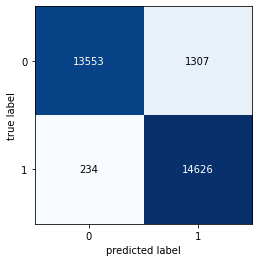

In [ ]:
plot_confusion_matrix(metrics.confusion_matrix(expected, predicted))

Давайте посмотрим, на какие твиты какие результаты дает модель
Выведем первые 10 результатов, чтобы не загружать нотбук

In [ ]:
# трейн дф
gg=X_test.reset_index(drop=True)
for i, p in enumerate(predicted):
    print(gg[i] + " - " + str(p))
    if i > 10:
        break

terry bradshaw amp george karl least insensitive remarks racist re melo mike tomlin trump emboldened - 1
user might libtard if libtard sjw liberal politics - 1
working saturday - 0
racism cease white priviledge must beast god help us this melanin poetry write - 1
user wohooo excited aaron cassie 11192016 wedding - 0
user trophy always one user educate yourself womenwednesdayâ - 1
good morning happy tuesday tuesday morning coffee fabdivas - 0
user whining women much harder men cause user - 1
multiple types racism america us america - 1
user user hello mahið hope good less day left watch playð indvszim - 0
sea shepherd suppoers racist antiracism seashepherd - 1
user hell juan decide kellyann raise kids work weve years cant standâ - 1


In [ ]:
# тест дф
predicted_nolabel=model.predict(tf_test_for_test)
for i, p in enumerate(tf_test_for_test):
    print(df_test.tweet[i] + " - " + str(predicted_nolabel[i]))
    if i > 10:
        break 

studiolife aislife requires passion dedication willpower find newmaterialsâ - 0
user white supremacists want everyone see new â birdsâ movie â hereâs - 1
safe ways heal acne altwaystoheal healthy healing - 0
hp cursed child book reservations already yes where no when ððð harrypotter pottermore favorite - 0
3rd bihday amazing hilarious nephew eli ahmir uncle dave loves missesâ - 0
choose momtips - 0
something inside dies ððâ eyes ness smokeyeyes tired lonely sof grungeâ - 0
finishedtattooinkedinkloveitâï âïâïâïâï thanksaleeee - 0
user user user never understand dad left young deep inthefeels - 0
delicious food lovelife capetown mannaepicure resturantâ - 0
1000dayswasted narcosis infinite ep make aware grinding neuro bass lifestyle - 0
one worlds greatest spoing events lemans24 teamaudi - 0


 Все хорошо!

Для того, чтобы убедиться, что модель работает более менее корректно дадим ей датафрейм с "плохими словами" и посмотрим на ее предсказания
( к сожалению, плохо помещается)

In [ ]:
test_custom=pd.DataFrame(["racist", "white judge trial",
                          "it is a horrible incident",
                          "@user #white #supremacists want everyone to see the new â  #birdsâ #movie â and hereâs why",
                          " @user #white #supremacists want everyone to see the new â  #birdsâ #movie â and hereâs why",
                          "@user  at work: attorneys for white officer who shot #philandocastile remove black judge from presiding over trial. htâ¦"])

In [ ]:
tf_custom = vector.transform(test_custom[0])
model.predict(tf_custom)


array([1, 1, 1, 1, 1, 1])

 Ура, модель правильно определила класс специально подсунутых слов
 